# Exercise 9 - CIFAR10 Challenge

## Group ID: 21
- Andrea Tufo
- Hongli Lin
- Michele Paterson
## Exercise day: Tuesday

## Task description:
In this exercise, you have all the freedom to come up with the best model, data augmentation, hyperparameters, loss function, etc. - essentially everything you have learned so far in the course - to achieve the highest possible accuracy on the CIFAR10 dataset.
You are allowed to use PyTorch functions for mechanisms which were covered in the previous exercises or lectures. But you are not allowed to use pre-trained models or any external dataset for training.
Also you have to provide a brief explanation of your model and all the decisions (hyperparameters, augmentation, etc.) you made to achieve the claimed accuracy.
To make the task more challenging, you have to train on an imbalanced traindataset.

Hint: For the final training process, you can use Google Colab which provides (time-restricted) free GPU resources.

## Submission:
- You have to submit a single .zip file containing this notebook and the weights of your model (model.pth).
- The total size of the .zip file must be less than 256MB. (absolute maximum, less is always better)
- The model file should be named model.pth.
- The test code at the end of your submitted notebook must run by only loading the provided model.pth file. We will not be able to run any training code.
- Upload the .zip via Ilias by clicking the **left** button called **"Datei hochladen"**(if you use the German version of Ilias). Please not use the right one, because Ilias will unzip your file in that case and can't handle .pth files.<br>
![](./upload.png)

## Evaluation:
The evaluation of the exercise is based on the achieved accuracy on the test dataset.
The baseline is 65% accuracy on the test dataset.

Note: The three best submissions will be awarded in the lecture with a small prize.

## Brief explanation of the model and the techniques used:
### Model Description 
We replicated the ResNext29 model for CIFAR-10:
https://arxiv.org/abs/1611.05431v2
- In short, the architecture utilizes more channels, but the channels are divided
into groups which don't share parameters between them. The number of groups
are called cardinarity and considered another hyperparameter important for 
fine-tuning.

According to this article, it performs better on CIFAR-10 comparing
to other CNN methods:
https://ieeexplore.ieee.org/abstract/document/10604269?casa_token=wK3e1i1MnKcAAAAA:9Uji_Pn9RWXctmx7_GeF8DnukBbJKLuNjPGppS4qY8b8s2IHzINBAR2WUg1JDKLVtZDLO5fXsA

### Other Decisions you made
- Augmentations: To deal with imbalanced data, we use a random choice of
CutMix and Mix up. Some other regular augmentation techniques are also applied.
As tested, Random Erasing does not help and may decrease the final accuracy.

- Batch Size: 128
- Number of Epochs: 120 but converges at around 100
- Learning rate: start at 0.001. After 30 and 60 epochs, decrease learning rate
by 1/10 to further finetune the model. The numbers are from experiences.


## Code:


### Imports and data loading

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB dat

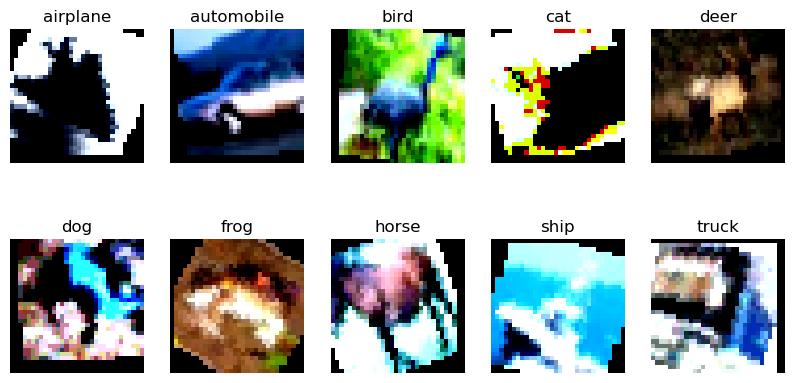

In [24]:
from torchvision.transforms import v2 as T

from torch.utils.data import WeightedRandomSampler

num_classes = 10
# deal with imbalanced dataset
cutmix = T.CutMix(num_classes=num_classes)
mixup = T.MixUp(num_classes=num_classes)
cutmix_or_mixup = T.RandomChoice([cutmix, mixup])

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = torch.tensor(mean, dtype=torch.float32)
std = torch.tensor(std, dtype=torch.float32)

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(list(mean), list(std))])
# transform_test = T.Compose([transforms.ToTensor()])
color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2)
transform_train = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(size=32, scale=(0.8,1)),
        T.RandomRotation(degrees=30),
        T.RandomApply([color_jitter], p=0.8),
        T.RandomInvert(p=0.2),
        T.RandomPosterize(bits=4, p=0.2),
        T.RandomSolarize(threshold=1, p=0.2),
        T.RandomEqualize(p=0.2),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=4),
        transforms.Normalize(list(mean), list(std))])

# transform_train = transform_test
batch_size = 32

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

number_samples_per_class = np.array(list(num_samples_per_class.values()))
weight = number_samples_per_class / number_samples_per_class.sum()
weight = 1 / weight
weight = weight / weight.sum()
targets = [trainset.targets[i] for i in imbalanced_indices]
samples_weight = np.array([weight[int(t)] for t in targets])
sampler = WeightedRandomSampler(samples_weight, num_samples=50000, replacement=True)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, sampler=sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

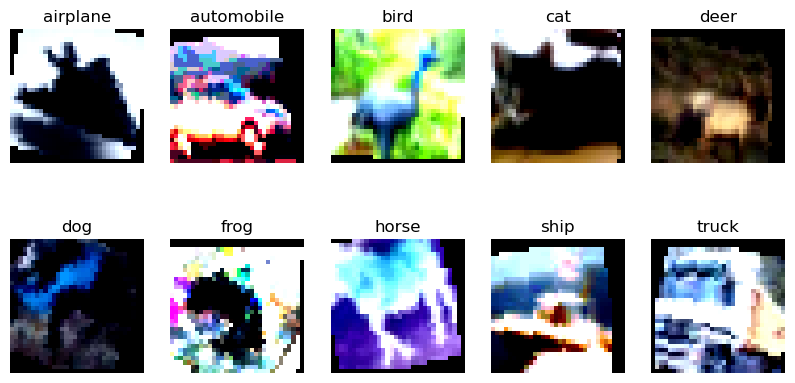

In [15]:
# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


### Model

Residual Blocks:

(i)if producing spatial maps of the same size, the blocks share
the same hyper-parameters (width and filter sizes), and 

(ii)
each time when the spatial map is downsampled by a factor of 2, the width of the blocks is multiplied by a factor
of 2.

ResNext performs well on CIFAR
https://arxiv.org/pdf/1611.05431v2

In [16]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, hiddenchannel, outchannel, stride=1, group = 1):
        super(ResidualBlock, self).__init__()
        # left: (in_size - 3 + 2)/s + 1 = (in_size -1)/s + 1 = out_size
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, hiddenchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, hiddenchannel, kernel_size=3, stride=stride, padding=1, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, outchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(outchannel),
        )
        # shortcut: (in_size - 1)/s + 1 = out_size
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                # zero padding to make the dimensions match
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNeXt29(nn.Module):
    def __init__(self, c_in=1, num_classes=10, cardinality=8):
        super(ResNeXt29, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            ResidualBlock(64, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
        )
        self.conv3 = nn.Sequential(
            ResidualBlock(256, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
        )
        self.conv4 = nn.Sequential(
            ResidualBlock(512, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
# ------------------------------
# Inception Block with Dropout
# ------------------------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

        # 3x3 max pooling branch followed by 1x1 convolution
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        branch1 = self.branch1x1(x)
        branch2 = self.branch3x3(x)
        branch3 = self.branch5x5(x)
        branch4 = self.branch_pool(x)
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout)

        # Skip connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Dropout after the first convolution
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.dropout(out)  # Dropout after the residual connection
        return out

class Model(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super(Model, self).__init__()

        # Initial Convolution Block
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

        # Residual Block 1
        self.res1 = ResidualBlock(128, 256, stride=2, dropout=dropout)

        # Inception Block 1
        self.inception1 = InceptionBlock(256, 256, dropout=dropout)

        # Residual Block 2
        self.res2 = ResidualBlock(256, 512, stride=2, dropout=dropout)

        # Inception Block 2
        self.inception2 = InceptionBlock(512, 512, dropout=dropout)

        # Residual Block 3
        self.res3 = ResidualBlock(512, 768, stride=2, dropout=dropout)

        # Inception Block 3
        self.inception3 = InceptionBlock(768, 768, dropout=dropout)

        # Additional Residual and Inception Blocks for Depth
        self.res4 = ResidualBlock(768, 1024, stride=2, dropout=dropout)
        self.inception4 = InceptionBlock(1024, 1024, dropout=dropout)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Dropout(0.5),          # Dropout before the final fully connected layer
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.res1(x)
        x = self.inception1(x)
        x = self.res2(x)
        x = self.inception2(x)
        x = self.res3(x)
        x = self.inception3(x)
        x = self.res4(x)
        x = self.inception4(x)
        x = self.classifier(x)
        return x

In [17]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.bias.data.zero_()


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride, cardinality):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = cardinality * out_channels // self.expansion

        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            groups=cardinality,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y


class Network(nn.Module):
    def __init__(self, config):
        super(Network, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        depth = config['depth']
        self.cardinality = config['cardinality']

        n_blocks_per_stage = (depth - 2) // 9
        assert n_blocks_per_stage * 9 + 2 == depth
        block = BottleneckBlock

        n_channels = [
            base_channels, base_channels * block.expansion,
            base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(n_channels[0])

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, stride=1)
        self.stage2 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, stride=2)
        self.stage3 = self._make_stage(
            n_channels[2], n_channels[3], n_blocks_per_stage, stride=2)

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]
            # print(self._forward_conv(torch.zeros(*input_shape)).shape)
            # print(self._forward_conv(torch.zeros(*input_shape)).view(-1).shape)
            # print('feature size:', self.feature_size)

        self.fc = nn.Linear(self.feature_size, n_classes)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name,
                    BottleneckBlock(
                        in_channels,
                        out_channels,
                        stride,  # downsample
                        self.cardinality))
            else:
                stage.add_module(
                    block_name,
                    BottleneckBlock(
                        out_channels,
                        out_channels,
                        1,  # no downsampling
                        self.cardinality))
        return stage

    def _forward_conv(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
config = {
    "n_classes": 10,
    "cardinality": 4,
    "depth": 29,
    "base_channels": 64,
    "input_shape": (1, 3, 32, 32),
}

In [27]:
import torchsummary
model = Network(config)
torchsummary.summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 256, 32, 32]          16,384
       BatchNorm2d-4          [-1, 256, 32, 32]             512
            Conv2d-5          [-1, 256, 32, 32]         147,456
       BatchNorm2d-6          [-1, 256, 32, 32]             512
            Conv2d-7          [-1, 256, 32, 32]          65,536
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
  BottleneckBlock-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]          65,536
      BatchNorm2d-13          [-1, 256, 32, 32]             512
           Conv2d-14          [-1, 256,

In [23]:
model = ResNeXt29( c_in=3, num_classes=10, cardinality=8).to(device)
torchsummary.summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           1,024
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 11, 11]          18,432
       BatchNorm2d-8          [-1, 128, 11, 11]             256
              ReLU-9          [-1, 128, 11, 11]               0
           Conv2d-10          [-1, 256, 11, 11]           4,096
      BatchNorm2d-11          [-1, 256, 11, 11]             512
           Conv2d-12          [-1, 256, 11, 11]          16,384
      BatchNorm2d-13          [-1, 256, 11, 11]             512
    ResidualBlock-14          [-1, 256,

In [9]:
class Optimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [10]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [30]:
def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_before = validate(model, testloader, device)
    print(f"Accuracy before training: {acc_before}")
    for epoch in range(num_epochs):
        lr_max = 1e-2
        lr_min = 1e-4
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / num_epochs * np.pi))
            if epoch < 5:
                param_group['lr'] = 1e-1 * (epoch + 1) / 10
            print(f"Learning rate: {param_group['lr']}")

        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # deal with imbalanced dataset
            inputs, labels = cutmix_or_mixup(inputs, labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [31]:
# model = ResNeXt29(c_in = 3, num_classes = 10)
# model = Model(num_classes=10)
model = Network(config)

criterion = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [29]:
train(model, trainloader, testloader, criterion, optimizer, num_epochs=150, device=device)

Accuracy before training: 0.1
Learning rate: 0.001


  6%|▌         | 94/1563 [01:18<20:27,  1.20it/s] 


KeyboardInterrupt: 

### Save the model

In [189]:
# save the model
torch.save(model.state_dict(), "model.pth")

### Load and test the model (this code will be used by us for testing)

```python

In [191]:
# load the model from .pth file
model = Model(num_classes=10)

model.load_state_dict(torch.load("model.pth", weights_only=True))

# test the model
model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

c:\Users\Admin\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Accuracy of the network on the 10000 test images: 87.34%


- Got 55% using additional weight in cross entropy loss

    I suspect it's because the weight further reduces the dataset.
    try using additional weight in sampling instead of in CE loss
    and increase sample size to 70000:
- Got 68% 

    Try to simply remove the cut and mix to see if the model can handle simpler
    information. Meanwhile change cardinality to 8, leaving at least 16 channels
    per group:
- Got 50% and slowly increasing. 

    Try to use the inception model from the other team:
- Got around 70% after 23 epochs. I don't see too much of improvement tbh.

    Try removing all the augmentations and use 
    ResNeXt again, introduce learning rate warm-up and decay
- After 19 epochs, training accuracy suddenly goes to 90%+ (learning rate drop),
 while testing accuracy remains at around 60%

    Try adding cut and mix back
- After 10 epocs, training accuracy goes to 80%, while testing accuracy remains
    at around 60%. 
    
    Try adding augmentations w.o. normalization, color jitters and rotations
- After 37 epochs, training accuracy goes to 80%+, while testing accuracy goes
    to 70%+. 
    
    Resuming rotations
- After 70 epochs, training -> 94%, testing -> 78%, 

    resuming color jittering:
- After 250 epochs, trainng -> 88%, testing -> 78%, 

    try reducing training set to 20000:
- Convergence slows down again, after 150 epochs, train: 78.41% test: 73.5%
    Looks like the total number of data matters even if the dataloader is sampling
    the same dataset over and over again. (Of course each sample has different
    augmentations). So more sampled data per epoch -> more stable gradient.
    But our model still cannot compete with that of the other team. I've tried using 
    their model and the gradient doesn't descent as rapid as theirs. I suspect
    it's because of their optimization technique is more suitable.

    Try AdamW: remove weight decay, set 10x learning rate from the start:
- 100 epochs: train: 70%, test: 67%; 150 epoches: train: 79%, test: 72%
    It seems that AdamW allows higher lr. 
    
    Now I try to increase data size
    to 100,000. Remember those are just balancely random selected images from 
    the imbalanced dataset, with random augmentations of course.
    
- 150 epochs: train: 97.5%, test: 77%
    This shows that our model/architecture is definitely able to overfit, so 
    the model complexity is **NOT** a big issue. Got to try stronger regularization
    or data augmentation.
    
    I prefer not to use dropout together with batch norm. See:
    https://arxiv.org/pdf/1801.05134

    Try resuming normalization first. With this, the differences left comparing
    to the submitted version are: the lr decay strategy, larger dataset per epoch
    and an AdamW optimizer.

- 100 epochs: train: 93%, test: 75%
    So the normalization doesn't make much difference

    Try more augmentations (invert, solarize, polirize, equalize, affine transforms)

    Note: There is an auto augment policy specially designed for CIFAR10 in 
    Pytorch:
     ```policy == AutoAugmentPolicy.CIFAR10:
            return [
                (("Invert", 0.1, None), ("Contrast", 0.2, 6)),
                (("Rotate", 0.7, 2), ("TranslateX", 0.3, 9)),
                (("Sharpness", 0.8, 1), ("Sharpness", 0.9, 3)),
                (("ShearY", 0.5, 8), ("TranslateY", 0.7, 9)),
                (("AutoContrast", 0.5, None), ("Equalize", 0.9, None)),
                (("ShearY", 0.2, 7), ("Posterize", 0.3, 7)),
                (("Color", 0.4, 3), ("Brightness", 0.6, 7)),
                (("Sharpness", 0.3, 9), ("Brightness", 0.7, 9)),
                (("Equalize", 0.6, None), ("Equalize", 0.5, None)),
                (("Contrast", 0.6, 7), ("Sharpness", 0.6, 5)),
                (("Color", 0.7, 7), ("TranslateX", 0.5, 8)),
                (("Equalize", 0.3, None), ("AutoContrast", 0.4, None)),
                (("TranslateY", 0.4, 3), ("Sharpness", 0.2, 6)),
                (("Brightness", 0.9, 6), ("Color", 0.2, 8)),
                (("Solarize", 0.5, 2), ("Invert", 0.0, None)),
                (("Equalize", 0.2, None), ("AutoContrast", 0.6, None)),
                (("Equalize", 0.2, None), ("Equalize", 0.6, None)),
                (("Color", 0.9, 9), ("Equalize", 0.6, None)),
                (("AutoContrast", 0.8, None), ("Solarize", 0.2, 8)),
                (("Brightness", 0.1, 3), ("Color", 0.7, 0)),
                (("Solarize", 0.4, 5), ("AutoContrast", 0.9, None)),
                (("TranslateY", 0.9, 9), ("TranslateY", 0.7, 9)),
                (("AutoContrast", 0.9, None), ("Solarize", 0.8, 3)),
                (("Equalize", 0.8, None), ("Invert", 0.1, None)),
                (("TranslateY", 0.7, 9), ("AutoContrast", 0.9, None))

    Next: higher learning rate?

- 100 epochs: train: 82%, test: 75%. The augmentations are now too strong for 
    the current model.

    Try increase model complexity: First remove cutmix and mixup. Use the model
    from the other team

- 150 epochs: train: 99%, test: 87.34% Bang!

    So overall, our model is systematically worse than that of the other team.
    The augmentations are not enough. The data input is not balanced correctly.
    The model is too simple. The learning rate should decay in a good way.


-> Found mistake in building ResNeXt
